In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer
from sklearn.linear_model import LinearRegression, RANSACRegressor

# Apply the default theme
sns.set_theme()

In [2]:
df = pd.DataFrame()
for path in glob.glob("./../networks_test/*"):
    df_tmp = pd.read_csv(path + "/transcriptions.csv")
    # df_tmp = df.set_index('ground_truth', drop=True)
    if len(df)==0:
        df = df_tmp[:]
    else:
        df = df.merge(df_tmp, on="ground_truth")
    
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# df.head()

In [7]:
networks = [
    'speechbrain/asr-crdnn-rnnlm-librispeech',
    'facebook/s2t-large-librispeech-asr',
    'facebook/wav2vec2-large-960h-lv60-self',
    'deepspeech-0.9.3-models.pbmm',
]

for col in df[networks]:
    df[col+"_wer"] = df[df.columns[~df.columns.str.contains('inf_time')]].apply(lambda x: wer(x['ground_truth'], x[col]), axis=1)
df.head()

,speechbrain/asr-crdnn-rnnlm-librispeech,speechbrain/asr-crdnn-rnnlm-librispeech_inf_time,ground_truth,facebook/s2t-large-librispeech-asr,facebook/s2t-large-librispeech-asr_inf_time,facebook/wav2vec2-large-960h-lv60-self,facebook/wav2vec2-large-960h-lv60-self_inf_time,deepspeech-0.9.3-models.pbmm,deepspeech-0.9.3-models.pbmm_inf_time,speechbrain/asr-crdnn-rnnlm-librispeech_wer,facebook/s2t-large-librispeech-asr_wer,facebook/wav2vec2-large-960h-lv60-self_wer,deepspeech-0.9.3-models.pbmm_wer
0,A MAN SAID TO THE UNIVERSE SIR I EXIST,7.215630,A MAN SAID TO THE UNIVERSE SIR I EXIST,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.149777,A MAN SAID TO THE UNIVERSE SIR I EXIST,5.198802,A MAN SAID TO THE UNIVERSE SIR I EXIST,3.528596,0.000000,0.000000,0.000000,0.000000
1,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,21.831181,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,3.593538,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,6.495734,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,5.097175,0.312500,0.187500,0.125000,0.437500
2,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,29.324319,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,6.903134,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,14.213657,THE CUD ON HIS CHEST STILL DRIPPEN BLOOD THE A...,11.627421,0.064516,0.032258,0.000000,0.290323
3,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,10.128328,HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL S...,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,2.650987,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,5.510652,ISTENSTANTE PANICK WAS FOLLOWED BY A SMALL SHA...,4.316641,0.066667,0.066667,0.066667,0.333333
4,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,7.656298,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,ONE MINUTE A VOICE SAID AND A TIME BUZZER SOUNDED,2.302589,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,5.017462,ONE MINUTE A VOIC SAID AND THE TIME BUS OR SOU...,3.818552,0.000000,0.100000,0.000000,0.300000


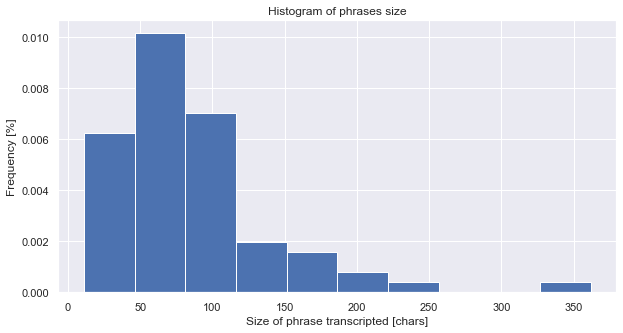

In [4]:
plt.figure(figsize=(10,5))
plt.hist(df['ground_truth'].str.len(), density=True)
plt.title("Histogram of phrases size")
plt.ylabel("Frequency [%]")
plt.xlabel("Size of phrase transcripted [chars]")
plt.show()

#chars = 6.5 * inf_time -1.4 for speechbrain/asr-crdnn-rnnlm-librispeech_inf_time
#chars = 25.0 * inf_time -0.3 for facebook/s2t-large-librispeech-asr_inf_time
#chars = 13.3 * inf_time -4.2 for facebook/wav2vec2-large-960h-lv60-self_inf_time
#chars = 17.0 * inf_time -3.7 for deepspeech-0.9.3-models.pbmm_inf_time


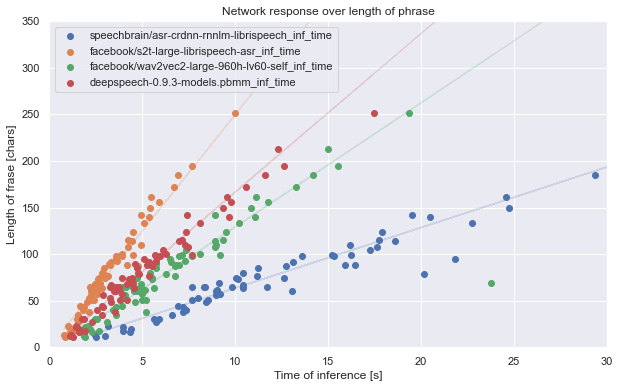

In [5]:
plt.figure(figsize=(10,6))

for col in df.columns[df.columns.str.contains('inf_time')]:

    X = df[col].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = df['ground_truth'].str.len().values.reshape(-1)  # -1 means that calculate the dimension of rows, but have 1 column
    robustreg = RANSACRegressor()  # create object for the class
    robustreg.fit(X, Y)  # perform linear regression
    Y_pred = robustreg.predict(X)  # make predictions
    plt.scatter(X, Y, label=col)
    plt.plot(X, Y_pred, alpha=0.2, linewidth=1,)
    print("#chars = {:.1f} * inf_time {:.1f} for {}".format(robustreg.estimator_.coef_[0], robustreg.estimator_.intercept_, col))

plt.legend()
plt.title("Network response over length of phrase")
plt.xlabel("Time of inference [s]")
plt.ylabel("Length of frase [chars]")
plt.legend()
plt.xlim([0, 30])
plt.ylim([0, 350])
plt.show()

In [6]:
df

,speechbrain/asr-crdnn-rnnlm-librispeech,speechbrain/asr-crdnn-rnnlm-librispeech_inf_time,ground_truth,facebook/s2t-large-librispeech-asr,facebook/s2t-large-librispeech-asr_inf_time,facebook/wav2vec2-large-960h-lv60-self,facebook/wav2vec2-large-960h-lv60-self_inf_time,deepspeech-0.9.3-models.pbmm,deepspeech-0.9.3-models.pbmm_inf_time,speechbrain/asr-crdnn-rnnlm-librispeech_wer,facebook/s2t-large-librispeech-asr_wer,facebook/wav2vec2-large-960h-lv60-self_wer,deepspeech-0.9.3-models.pbmm_wer
0,A MAN SAID TO THE UNIVERSE SIR I EXIST,7.215630,A MAN SAID TO THE UNIVERSE SIR I EXIST,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.149777,A MAN SAID TO THE UNIVERSE SIR I EXIST,5.198802,A MAN SAID TO THE UNIVERSE SIR I EXIST,3.528596,0.000000,0.000000,0.000000,0.000000
1,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,21.831181,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,3.593538,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,6.495734,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,5.097175,0.312500,0.187500,0.125000,0.437500
2,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,29.324319,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,6.903134,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,14.213657,THE CUD ON HIS CHEST STILL DRIPPEN BLOOD THE A...,11.627421,0.064516,0.032258,0.000000,0.290323
3,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,10.128328,HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL S...,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,2.650987,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,5.510652,ISTENSTANTE PANICK WAS FOLLOWED BY A SMALL SHA...,4.316641,0.066667,0.066667,0.066667,0.333333
4,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,7.656298,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,ONE MINUTE A VOICE SAID AND A TIME BUZZER SOUNDED,2.302589,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,5.017462,ONE MINUTE A VOIC SAID AND THE TIME BUS OR SOU...,3.818552,0.000000,0.100000,0.000000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,I DON'T BELIEVE ANNE KNEW ANY MAGIC OR SEED OF...,9.845124,I DON'T BELIEVE ANN KNEW ANY MAGIC OR SHE'D HA...,I DON'T BELIEVE ANNE KNEW ANY MAGIC OR SHE'D H...,2.566986,I DON'T BELIEVE ANNE KNEW ANY MAGIC OR SHE'D H...,4.526741,I DON'T BELIEVE ANNE NEW ANY MAGIC OR SHE THE ...,3.506512,0.384615,0.076923,0.076923,0.461538
69,I DO NOT KNOW CONFESSED SHAGGY,5.897659,I DO NOT KNOW CONFESSED SHAGGY,I DO NOT KNOW CONFESSED SHAGGY,1.749152,I DO NOT KNOW CONFESSED SHAGGY,2.598034,I DO NOT KNOW CONFESSED SHAGGY,1.886534,0.000000,0.000000,0.000000,0.000000
70,TRUE AGREED CALICO,3.981032,TRUE AGREED KALIKO,TRUE AGREED KALIKO,1.301279,TRUE A GREEN CALICO,2.687417,TRUE A GREED CALICOL,1.933523,0.333333,0.000000,1.000000,1.000000
71,CALICO WENT TO THE BIG GONG AND POUNDED ON IT ...,17.238874,KALIKO WENT TO THE BIG GONG AND POUNDED ON IT ...,KALIKO WENT TO THE BIG GONG AND POUNDED ON IT ...,928.133193,CALICO WENT TO THE BIG GONG AND POUNDED ON IT ...,7.377811,CALICO WENT TO THE BIG GONG AND POUNDED ON IT ...,6.115829,0.090909,0.000000,0.090909,0.181818
